# Train with more companies and predict on future data

In [16]:
import sys
sys.executable

'C:\\ieu\\Anaconda3\\envs\\spark\\python.exe'

In [17]:
from pathlib import Path
from typing import List, Tuple, Union, Set
import glob

import pandas as pd
import numpy as np

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

from pyspark.sql.functions import col

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
print("sns-version: ", sns.__version__)

# there are issues when using sns scatterplot (replot) with matplotlib version 3.3.1, so we have to check if it is actual
print("matplotlib-version: ", matplotlib.__version__)

sns-version:  0.10.1
matplotlib-version:  3.3.2


In [18]:
trainingset_folder    = "D:/data_mt/09_training/"
stock_data_folder = trainingset_folder + "stocks/"
combine_data_folder = trainingset_folder + "combined/"

combined_data_file = trainingset_folder + "/all_combine_data"

model_folder = "D:/data_mt/10_models/"
model_name   = "06_robo_advisor_predictor"

## 01_Tools

In [19]:
def load_additional_info_spark():
    return spark.read.csv(trainingset_folder + "company_info.csv", header=True, dateFormat="yyyy-MM-dd", inferSchema=True)

In [20]:
def load_additional_info() -> pd.DataFrame:
    return pd.read_csv(trainingset_folder + "company_info.csv", sep=',', encoding='utf-8', header=0)

In [21]:
import findspark
from pyspark.sql import SparkSession
def get_spark_session(appname = "default"):
    """
    Initialises a spark session. 
    Parameters:
    appname - default is "default"
    """
    findspark.init()
    return SparkSession.builder \
                        .appName(appname) \
                        .getOrCreate()

In [22]:
# init Spark
spark = get_spark_session() # Session anlegen
spark # display the moste important information of the session

## 02_Load Data

In [23]:
add_info_spark = load_additional_info_spark()

In [24]:
df_all = spark.read.parquet(combined_data_file)
df_all.count()

4365181

In [25]:
df_joined = df_all.join(add_info_spark, ["ticker"], "left")

In [26]:
add_info = load_additional_info()

## 03_Build Train and Testdata
"close_norm" is removed.
features for sectors and industries are added.

In [27]:
features = ['r_workcapToAssets', 'r_currentRatio', 'r_deptToEquity', 'r_deptRatio', 'r_netProfitMargin', 'r_operatingMargin', 'r_netIncomeMargin', 
            'r_cashGenPowerRatio', 'r_extFinancingIndexRatio', 'r_returnOnEquity', 'r_returnOnAssets', 'r_assetsTurnoverRatio', 'r_dividendPayoutRatio', 
            'r_stockRepurchaseRatio', 'r_operatingCashFlowRatio', 'r_assetEfficiencyRatio', 'r_currentLiabCoverageRatio', 'r_longtermDeptCoverageRatio',
            
            'gr_revenue_n', 'gr_revenue_p', 'gr_grosspr_n', 'gr_grosspr_p', 'gr_opiincome_n', 'gr_opiincome_p', 'gr_netincome_n', 'gr_netincome_p', 
            'gr_earnings_n', 'gr_earnings_p', 'gr_equity_n', 'gr_equity_p', 'gr_asscur_n', 'gr_asscur_p', 'gr_assnoncur_n', 'gr_assnoncur_p', 
            'gr_liabcur_n', 'gr_liabcur_p', 'gr_liabnoncur_n', 'gr_liabnoncur_p', 'gr_cashfrominv_n', 'gr_cashfrominv_p', 
            'gr_cashfromfin_n', 'gr_cashfromfin_p', 'gr_cashfromope_n', 'gr_cashfromope_p', 'gr_dividends_n', 'gr_dividends_p',
            'fp__FY', 'fp__Q1', 'fp__Q2', 'fp__Q3', 'fp__Q4',
            
            'high_norm', 'low_norm', 'open_norm', 'volume_norm', 'close_chg', 'volume_chg', 

            'pr_p2e', 'pr_p2b', 'pr_p2egr_1y',
            
            'sec__BasicMaterials', 'sec__CommunicationServices', 'sec__ConsumerCyclical', 'sec__ConsumerDefensive', 'sec__Energy', 'sec__FinancialServices',
            'sec__Healthcare',  'sec__IndustrialGoods', 'sec__Industrials', 'sec__RealEstate', 'sec__Technology', 'sec__Utilities',
            
            'ind__AerospaceDefense', 'ind__ApparelRetail', 'ind__AssetManagement', 'ind__AutoParts', 'ind__BanksRegional', 'ind__Biotechnology', 
            'ind__CommunicationEquipment',              'ind__CreditServices', 'ind__DiagnosticsResearch', 'ind__ElectronicComponents', 
            'ind__InformationTechnologyServices', 'ind__InsurancePropertyCasualty', 'ind__MedicalDevices', 'ind__MedicalInstrumentsSupplies',
            'ind__OilGasEP', 'ind__OilGasEquipmentServices', 'ind__OilGasMidstream', 'ind__Other', 'ind__PackagedFoods', 'ind__Restaurants',
            'ind__ScientificTechnicalInstruments', 'ind__SemiconductorEquipmentMaterials', 'ind__Semiconductors', 'ind__SoftwareApplication',
            'ind__SoftwareInfrastructure', 'ind__SpecialtyBusinessServices', 'ind__SpecialtyChemicals', 'ind__SpecialtyIndustrialMachinery',
            'ind__SpecialtyRetail',
           ]

label =    'r_potential'

all_cols = list(features)
all_cols.append(label)

In [28]:
filter_no_potential = "r_potential > -1.0" 
filter_date_before_2017 = "Date < '2017-01-01'"
filter_date_from_2017 = "Date >= '2017-01-01'"

In [29]:
top_500 = add_info[add_info.mc_top500 == 1].ticker.to_list()

### define traindata Top500 company and 'Date' < 1.1.2017

In [17]:
df_train_canditates = df_joined.where(col('ticker').isin(top_500)) \
                      .where(filter_no_potential) \
                      .where(filter_date_before_2017) \
                      .select(all_cols)

In [18]:
df_train_canditates.count()

570572

In [19]:
# define what the label column is
df_train_canditates = df_train_canditates.withColumn("label", col('r_potential'))

In [20]:
df_train_canditates = df_train_canditates.na.drop(how="any")
df_train_canditates.count()

570563

In [21]:
# since the data are generally similar, we select only 50% as real trainingdata. 
# we will not be using the testdata, that is defined here, since we will use data with a date value after 1.1.2017
(trainingData, testData) = df_train_canditates.randomSplit([0.5, 0.5])

In [22]:
trainingData.count()

285428

## 04 Train Model
Follow https://www.silect.is/blog/random-forest-models-in-spark-ml/

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=features, outputCol="features")

rf = RandomForestRegressor(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=[assembler, rf])

In [24]:
from pyspark.ml.tuning import ParamGridBuilder

# a first test showed that numOfTrees with 50 and max depth of 25 was a good starting point
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50]) \
    .addGrid(rf.maxDepth, [25]) \
    .build()

In [25]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [26]:
# Note: Training time was 2hours
cvModel = crossval.fit(trainingData)

In [27]:
# save Model for further reference
best_model = cvModel.bestModel
best_model.write().overwrite().save(model_folder + model_name)

## 05 Load Model

In [30]:
# Load Model
from pyspark.ml import PipelineModel
pipeline = PipelineModel.load(model_folder + model_name)

## 06 Feature Importance

Text(0.5, 1.0, 'Feature Importances')

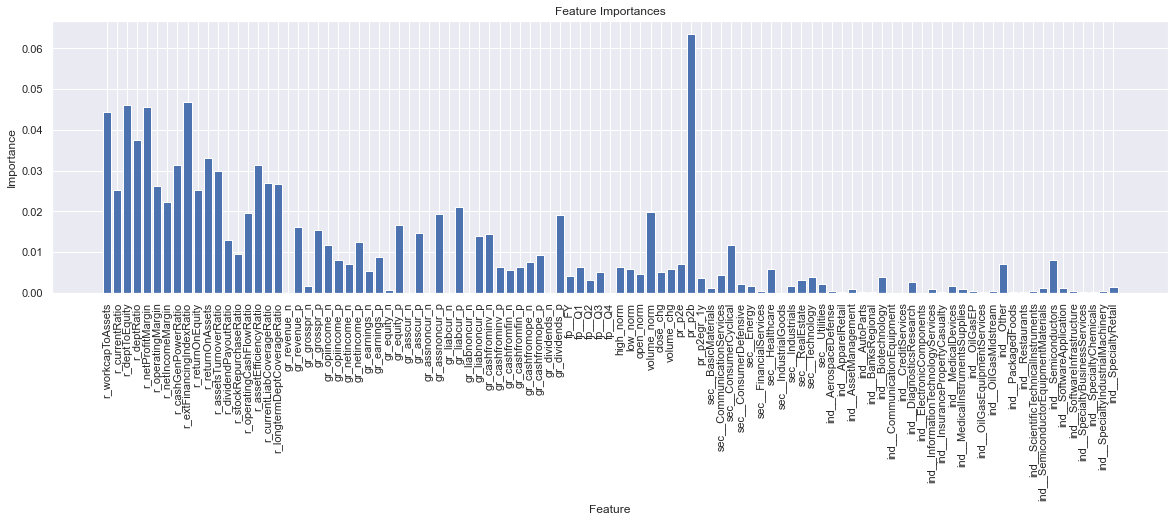

In [31]:
model = pipeline.stages[1]
importances = model.featureImportances
x_values = list(range(len(importances)))

f, ax = plt.subplots(figsize=(20,5))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

## 07_Create testdata and predict
The base testdataset contains all unseen data of all 2000+ companies.

In [32]:
testdata = df_joined.where(col('ticker').isin(top_500)) \
                 .where(filter_no_potential) \
                 .where(filter_date_from_2017)          
testdata.count()

424637

In [33]:
# for some reason there is a data point which has a null value somewhere.. so we make sure that there are no null values
testdata = testdata.na.drop(how="any")
testdata.count()

424626

In [34]:
df_predicted = pipeline.transform(testdata)

In [35]:
# create pandas dataframe
df_predicted_pd_orig = df_predicted.drop('features').toPandas()
df_predicted_pd = df_predicted_pd_orig.copy()

## 08_Create DataFile for Robo Advisor

In [119]:
# only these columns are needed
robo_train_cls = ['ticker', 'Date', 'r_potential','prediction', 'Close','High','Low', 'Open', 'close_norm']
robo_advisor_df = df_predicted_pd[robo_train_cls].copy()

In [120]:
robo_advisor_df['Date'] = pd.to_datetime(robo_advisor_df.Date)

# there are some duplicated entries
pred_mins = robo_advisor_df.groupby(['Date', 'ticker']).prediction.transform(min)
robo_advisor_df = robo_advisor_df.loc[robo_advisor_df.prediction == pred_mins]

# there are some dates who have only a few entries
date_counts = robo_advisor_df.Date.value_counts()
less = date_counts[date_counts < 400].index.tolist()
pd_ra_data_df = robo_advisor_df[~robo_advisor_df.Date.isin(less)]

In [121]:
# not every company is traded on everyday. in order make the code easier, these gaps are filled
# we create a new dataframe that just contains date and ticker of the missing entries
trading_dates = set(robo_advisor_df.Date.to_list())
companies = robo_advisor_df.ticker.unique()

new_rows = []

for company in companies:
    dates_of_company = set(robo_advisor_df[robo_advisor_df.ticker == company].Date.tolist())
    diff = trading_dates - dates_of_company
    for date in diff:
        dict = {'Date':date, 'ticker':company}
        new_rows.append(dict)
new_entries_df = pd.DataFrame(new_rows)

In [122]:
# now we can merge the entries and use ffill() to copy the values from the prior existing trading day
pd_ra_data_df = pd.merge(robo_advisor_df, new_entries_df, how="outer", on=['Date','ticker'])
pd_ra_data_df.set_index('Date', inplace=True)
pd_ra_data_df.sort_index(inplace = True)
pd_ra_data_df[['r_potential', 'prediction','Close','High','Low','Open','close_norm']] = pd_ra_data_df.groupby('ticker').transform(lambda v: v.ffill())

In [124]:
pd_ra_data_df.reset_index(inplace=True)

In [ ]:
pd_ra_data_df.sort_values(['ticker','Date']).to_csv(trainingset_folder + "robo_train_set.csv", header=True, index=False)

## 08_Analysis

### Tools

In [34]:
# to be able to filter directly on the year, let's add a year column
df_predicted_pd['close_year'] = pd.DatetimeIndex(df_predicted_pd['Date']).year

In [35]:
def calc_rsme(df:pd.DataFrame):
    rmse = ((df.r_potential-df.prediction)**2).mean()**0.5
    return rmse

In [36]:
def draw_scatter(df_arr:List[pd.DataFrame], labels: List[str]):
    number = len(df_arr)
    fig, ax = plt.subplots(1, number, figsize=(number * 7,5))

    if number > 1:
        for i in range(number):
            ax[i].plot(df_arr[i].r_potential, df_arr[i].prediction,'b.')

            ax[i].set_title(labels[i])
            
            ax[i].set_ylim(-1,5)
            ax[i].set_xlim(-1,10)
            

            ax[i].set(xlabel='Potential', ylabel='Prediction')
    else:
            ax.plot(df_arr[0].r_potential, df_arr[0].prediction,'b.')

            ax.set_title(labels[0])

            ax.set_ylim(-1,5)
            ax.set_xlim(-1,10)
            
            ax.set(xlabel='Potential', ylabel='Prediction')

In [37]:
def create_groups(df:pd.DataFrame) -> List[pd.DataFrame]:
    pred_all =     df
    pred_min_10 =  df[df.prediction >  0.1]
    pred_min_30 =  df[df.prediction >  0.3]
    pred_min_50 =  df[df.prediction >  0.5]
    pred_min_75 =  df[df.prediction >  0.75]
    pred_min_100 = df[df.prediction >  1.0]
    pred_min_150 = df[df.prediction >  1.5]

    data_sets = [pred_all, pred_min_10, pred_min_30, pred_min_50, pred_min_75, pred_min_100, pred_min_150]
    return data_sets

group_labels = ['all', 'above 10%', 'above 30%','above 50%','above 75%','above 100%','above 150%']

In [38]:
def draw_box(list_df:List[pd.DataFrame]):
    data = [x.r_potential.tolist() for x in list_df]

    fig, ax = plt.subplots(figsize=(20,7))
    ax.boxplot(data, showmeans=True)
    ax.set_ylim(-1,3)
    plt.xticks(np.arange(len(group_labels))+1, group_labels)
    plt.show()

### Overall

In [39]:
df_predicted_pd=df_predicted_pd[df_predicted_pd.r_potential<15]

In [40]:
print("Overall Model Performance RMSE: %f" % calc_rsme(df_predicted_pd))

Overall Model Performance RMSE: 0.401875


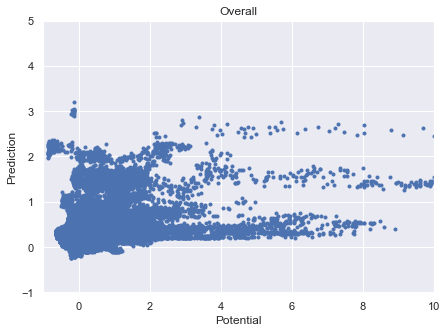

In [41]:
draw_scatter([df_predicted_pd],['Overall'])

### by Year Top 500

In [42]:
df_2017 = df_predicted_pd[(df_predicted_pd.close_year == 2017)]
df_2018 = df_predicted_pd[(df_predicted_pd.close_year == 2018)]
df_2019 = df_predicted_pd[(df_predicted_pd.close_year == 2019)]
df_2020 = df_predicted_pd[(df_predicted_pd.close_year == 2020)]

In [43]:
print("2017 Model Performance RMSE: %f" % calc_rsme(df_2017))
print("2018 Model Performance RMSE: %f" % calc_rsme(df_2018))
print("2019 Model Performance RMSE: %f" % calc_rsme(df_2019))
print("2020 Model Performance RMSE: %f" % calc_rsme(df_2020))

2017 Model Performance RMSE: 0.409375
2018 Model Performance RMSE: 0.316919
2019 Model Performance RMSE: 0.411977
2020 Model Performance RMSE: 0.524425


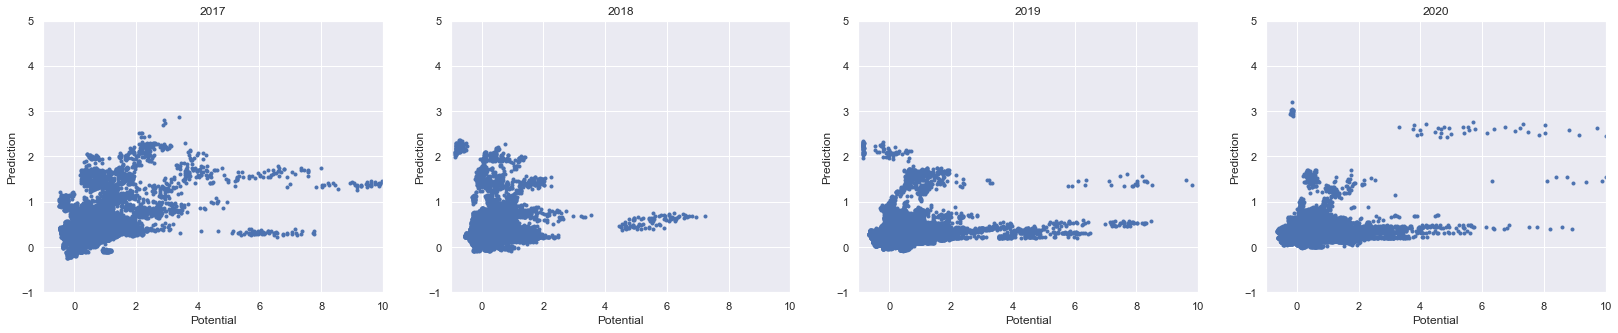

In [44]:
draw_scatter([df_2017, df_2018, df_2019,df_2020],['2017','2018','2019','2020'])

### Groups by year

In [52]:
groups_top500_all = create_groups(df_predicted_pd)
groups_top500_2017 = create_groups(df_2017)
groups_top500_2018 = create_groups(df_2018)
groups_top500_2019 = create_groups(df_2019)
groups_top500_2020 = create_groups(df_2020)

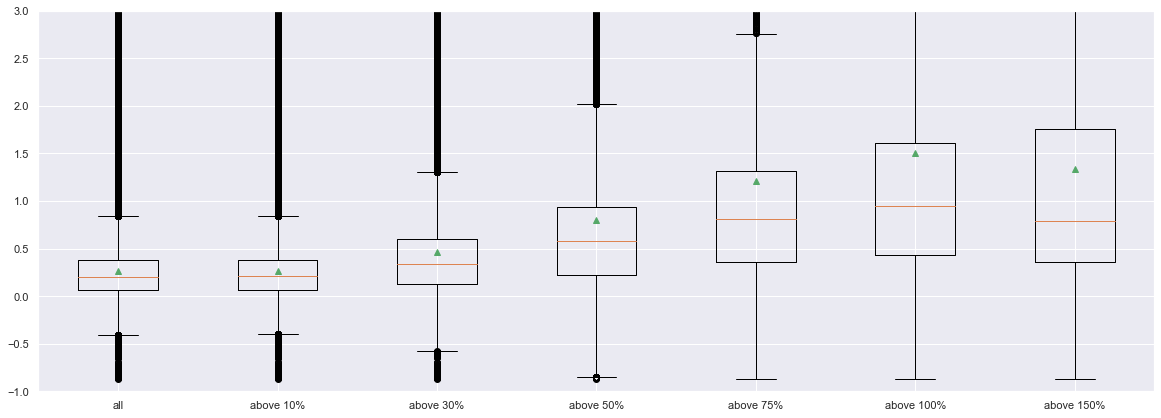

In [53]:
draw_box(groups_top500_all)

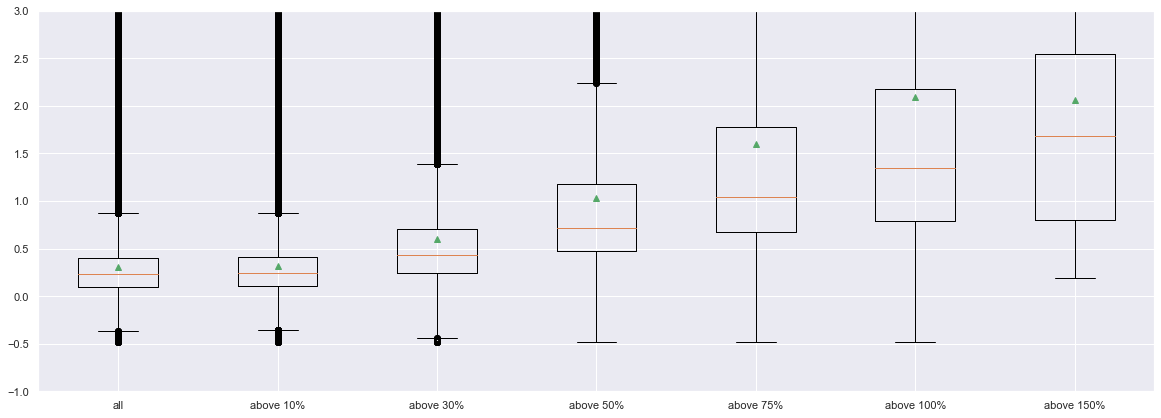

In [54]:
draw_box(groups_top500_2017)

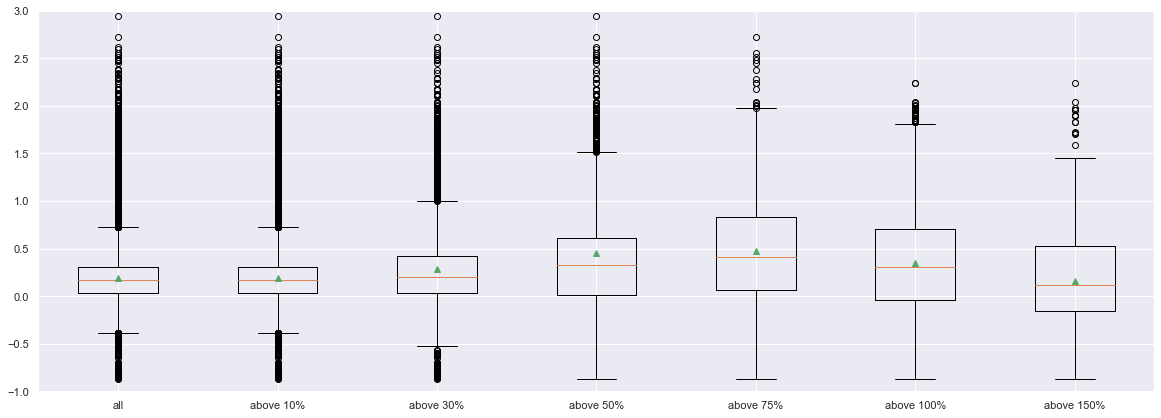

In [55]:
draw_box(groups_top500_2018)

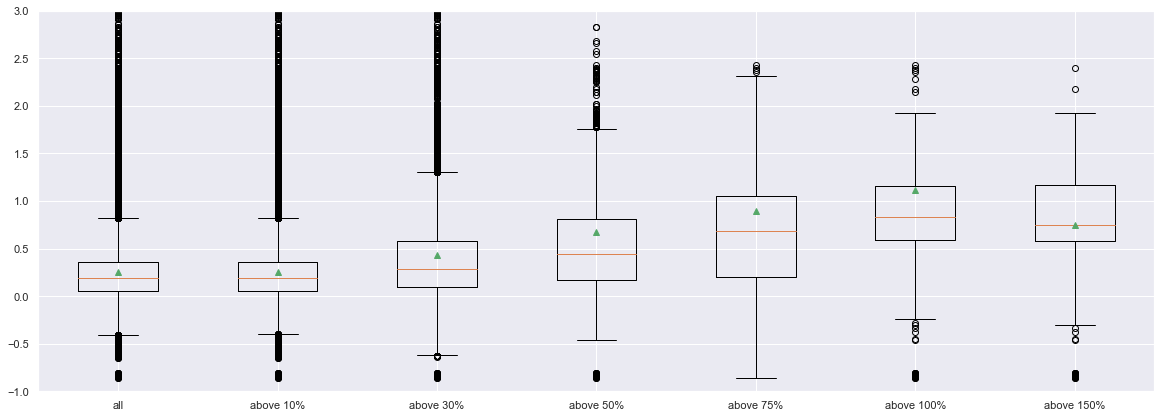

In [56]:
draw_box(groups_top500_2019)

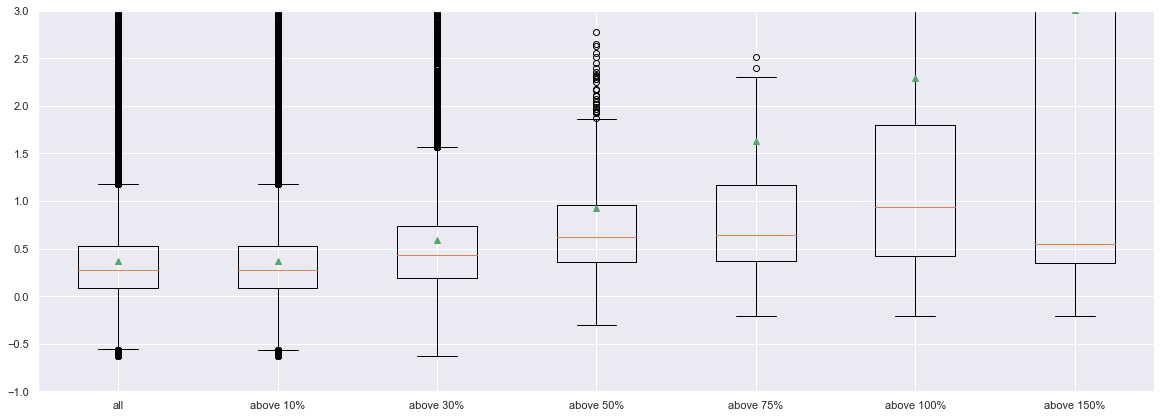

In [57]:
draw_box(groups_top500_2020)

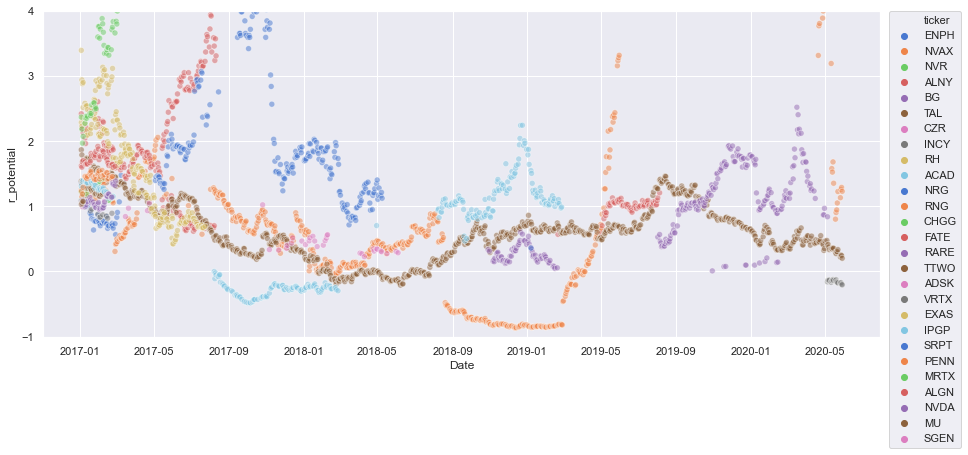

In [58]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(x="Date", y="r_potential", hue="ticker",  #size="prediction",
            sizes=(40, 400), alpha=.5, palette="muted",
            ax = ax, data= groups_top500_all[5])
ax.set_ylim(-1,4)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

## 99_stop spark

In [144]:
spark.stop()

## XX_Trials

In [99]:
import pandas as pd

ROBO_ADVISOR_DATA_FILE = "D:/data_mt/09_training/robo_train_set.csv"

pd_ra_data_df = pd.read_csv(ROBO_ADVISOR_DATA_FILE, sep=',', encoding='utf-8', header=0)
pd_ra_data_df['Date'] = pd.to_datetime(pd_ra_data_df.Date)

# there are some duplicated entries
pred_mins = pd_ra_data_df.groupby(['Date', 'ticker']).prediction.transform(min)
pd_ra_data_df = pd_ra_data_df.loc[pd_ra_data_df.prediction == pred_mins]

# there are some dates who have only a few entries
date_counts = pd_ra_data_df.Date.value_counts()
less = date_counts[date_counts < 400].index.tolist()
pd_ra_data_df = pd_ra_data_df[~pd_ra_data_df.Date.isin(less)]

In [102]:
# not every company is traded on everyday. in order make the code easier, these gaps are filled
# we create a new dataframe that just contains date and ticker of the missing entries
trading_dates = set(pd_ra_data_df.Date.to_list())
companies = pd_ra_data_df.ticker.unique()

new_rows = []

for company in companies:
    dates_of_company = set(pd_ra_data_df[pd_ra_data_df.ticker == company].Date.tolist())
    diff = trading_dates - dates_of_company
    for date in diff:
        dict = {'Date':date, 'ticker':company}
        new_rows.append(dict)
new_entries_df = pd.DataFrame(new_rows)

In [105]:
# now we can merge the entries and use ffill() to copy the values from the prior existing trading day
pd_ra_data_df = pd.merge(pd_ra_data_df, new_entries_df, how="outer", on=['Date','ticker'])
pd_ra_data_df.set_index('Date', inplace=True)
pd_ra_data_df.sort_index(inplace = True)
pd_ra_data_df_copy[['r_potential', 'prediction','Close','High','Low','Open','close_norm']] = pd_ra_data_df_copy.groupby('ticker').transform(lambda v: v.ffill())

(1317, 2)

In [114]:
date_counts = pd_ra_data_df.Date.value_counts()
date_counts.value_counts()

497    857
Name: Date, dtype: int64

In [70]:
print(pd_ra_data_df.shape)
print(pd_ra_data_df.Date.min())
print(len(pd_ra_data_df.ticker.unique()))
pd_ra_data_df.head()

(424620, 10)
2017-01-03 00:00:00
497


,ticker,Date,r_potential,prediction,Close,High,Low,Open,close_norm,day_of_week
0,A,2017-01-03,0.487546,0.362584,44.974556,45.226079,44.249004,44.432809,0.386379,1
1,A,2017-01-04,0.468281,0.363543,45.564671,45.835546,45.293799,45.400214,0.391449,2
2,A,2017-01-05,0.485948,0.330695,45.022934,45.535656,44.848801,45.516308,0.386795,3
3,A,2017-01-06,0.441051,0.353022,46.425671,46.503061,45.042284,45.110002,0.398846,4
4,A,2017-01-09,0.437606,0.361714,46.570778,46.977089,46.348276,46.445014,0.400093,0


In [52]:
pd_ra_data_df[pd_ra_data_df.Date == "2017-01-02"]

,ticker,Date,r_potential,prediction,Close,High,Low,Open,close_norm,day_of_week
172955,GPS,2017-01-02,0.57807,0.392972,18.990679,19.269953,18.829884,18.982216,0.870733,0


In [65]:
# there are some dates who have only a few entries
date_counts = pd_ra_data_df.Date.value_counts()
less = date_counts[date_counts < 400].index.tolist()
pd_ra_data_df = pd_ra_data_df[~pd_ra_data_df.Date.isin(less)]

In [47]:
pd.to_datetime("2017-01-01") + pd.DateOffset(days=7)

Timestamp('2017-01-08 00:00:00')

In [50]:
trading_dates = np.sort(pd_ra_data_df.Date.unique())

array(['2017-01-02T00:00:00.000000000', '2017-01-03T00:00:00.000000000',
       '2017-01-04T00:00:00.000000000', '2017-01-05T00:00:00.000000000',
       '2017-01-06T00:00:00.000000000', '2017-01-09T00:00:00.000000000',
       '2017-01-10T00:00:00.000000000', '2017-01-11T00:00:00.000000000',
       '2017-01-12T00:00:00.000000000', '2017-01-13T00:00:00.000000000',
       '2017-01-17T00:00:00.000000000', '2017-01-18T00:00:00.000000000',
       '2017-01-19T00:00:00.000000000', '2017-01-20T00:00:00.000000000',
       '2017-01-23T00:00:00.000000000', '2017-01-24T00:00:00.000000000',
       '2017-01-25T00:00:00.000000000', '2017-01-26T00:00:00.000000000',
       '2017-01-27T00:00:00.000000000', '2017-01-30T00:00:00.000000000',
       '2017-01-31T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-02-02T00:00:00.000000000', '2017-02-03T00:00:00.000000000',
       '2017-02-06T00:00:00.000000000', '2017-02-07T00:00:00.000000000',
       '2017-02-08T00:00:00.000000000', '2017-02-09